<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/MEC647_Fracture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

try:
    import pyvista
except ImportError:
    !{sys.executable} -m pip install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh


In [2]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade PyYAML
# !pip install --ignore-installed PyYAML



# Fracture


Let $\Omega \subset (0, L)^D$, with $D=1, 2, 3$, $L$ finite, being the (or one) characteristic length of the specimen.
For any 
- displacement field $u\in V_t : H^1(\Omega, R^n) + bcs(t)$ with $n=1, 2$ or $3$, and
- damage field $\alpha \in H^1(\Omega, R)$,

consider the energy $E(u, \alpha)$ defined as
$$
E_\ell(u, \alpha)=\frac{1}{2}\int_\Omega a(\alpha) W(u) dx + \underbrace{\frac{G_c}{c_w} \int \left(\frac{1}{\ell}w(\alpha) + \ell |\nabla \alpha|^2 \right)dx}_{\text{Surface energy}}- \int_\Omega f.u dx$$

In practice, $\ell \ll L$.

Above, $W$ is the elastic energy density, reading (in linearised elasticity as) 
$$ W(u) = Ae(u):e(u)
$$
where $A$ is the 4-th order tensor of elasticity, in the isotropic and homogeneous case, it corresponds to a linear combination with two coefficients, say, $A_0$ the stiffness (dimensional), and $\nu$ the Poisson ratio (non-dimensional). 


Further, $w(\alpha)$ corresponds to the dissipated energy to damage, homogeneously, the specimen, the gradient term accounts for spatial variations.

**Keypoint:** these two terms are weighted by $\ell$, a parameter that is homogeneous to a length and is understood as a *material* quantity (as opposed to *numerical*).

Define $D(\alpha_0):=\left\{ \alpha \in H^1(\Omega), \alpha \geq \alpha_0 \right\}$, for some $\alpha_0(x)\geq 0$ pointwise. 

We solve two types of problems (by increasing difficulty):
- **The static problem**: Given a load (boundary conditions) and an initial state of damage $\alpha_0$, what is the equilibrium displacement and repartition of damage?
In other terms:
$$\operatorname{ min loc} \left\{ E_\ell(u, \alpha):  u \in V_t, \alpha \in D(\alpha_0) \right\}$$. 

- **The evolution problem**: Given a load **history** (boundary conditions as a function of $t$) and an initial state of damage $\alpha_0$, what is the *evolution* of equilibrium displacement and repartition of damage, i.e. 
the map $t\mapsto (u_t, \alpha_t)$, such that 
  - (Irrevers.) $\alpha_t \nearrow t$,
  - (Stability) $(u_t, \alpha_t) = \operatorname{arg loc min} \left\{ E_\ell (v, \beta), (v, \beta) \in V_t \times D(\alpha_t) \right\}$ 



### Parameters

In the energy above:
- Two elasticity parameters, such as
  - $A_0$ the stiffness of the sound material
  - $\nu$ the Poisson ratio
  - equivalently, $\mu, \lambda$ the Lamé parameters
- Two fracture/damage parameters:
  - $\ell$ the internal damage length
  - $G_c$ the material toughness


### Back of the envelope computation.

1. Show that the energy above can be written as a function of only two non-dimensional parameters (ex.: $\nu, \tilde \ell)$, by dimensional analysis.

In [3]:
# library include

import numpy as np
import yaml
import json
import sys
import os
from pathlib import Path

from mpi4py import MPI

import petsc4py
from petsc4py import PETSc

import dolfinx
import dolfinx.plot
from dolfinx import log
import ufl


from dolfinx.io import XDMFFile

import logging

logging.basicConfig(level=logging.INFO)

import dolfinx
import dolfinx.plot
import dolfinx.io
from dolfinx.fem import (
    Constant,
    Function,
    FunctionSpace,
    assemble_scalar,
    dirichletbc,
    form,
    locate_dofs_geometrical,
    set_bc,
)
import matplotlib.pyplot as plt

In [4]:
!rm -rf mec647
try:
  !git clone https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')
  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git


Cloning into 'mec647'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (479/479), done.
remote: Total 588 (delta 258), reused 259 (delta 90), pack-reused 0
Receiving objects: 100% (588/588), 12.30 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (258/258), done.


In [5]:
sys.path.append('mec647/')

# meshes
import meshes
from meshes import primitives


In [6]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1,
        'nteps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.1
    },
    'model': {
        'E': 1.,
        'nu': 0.,
        'w1': 1.,
        'ell': 0.1,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        }
    }
}

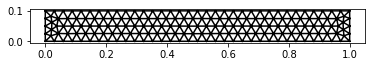

In [7]:
# Mesh

Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]

gmsh_model, tdim = primitives.mesh_bar_gmshapi(geom_type,
                                    Lx, 
                                    Ly, 
                                    0.03, 
                                    tdim=2)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh

plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")


In [15]:
# Functional Setting

element_u = ufl.VectorElement("Lagrange", mesh.ufl_cell(),
                              degree=1, dim=2)

element_alpha = ufl.FiniteElement("Lagrange", mesh.ufl_cell(),
                              degree=1)

V_u = dolfinx.fem.FunctionSpace(mesh, element_u) 
V_alpha = dolfinx.fem.FunctionSpace(mesh, element_alpha) 

u = dolfinx.fem.Function(V_u, name="Displacement")
u_ = dolfinx.fem.Function(V_u, name="BoundaryDisplacement")


alpha = dolfinx.fem.Function(V_alpha, name="Damage")

# Bounds
alpha_ub = dolfinx.fem.Function(V_alpha, name="UpperBoundDamage")
alpha_lb = dolfinx.fem.Function(V_alpha, name="LowerBoundDamage")

dx = ufl.Measure("dx", domain = mesh)
ds = ufl.Measure("ds", domain = mesh)
# dS = ufl.Measure("dS", domain = mesh)  - inner boundaries of the mesh


In [10]:
# Boundary sets

dofs_alpha_left = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], 0.))
dofs_alpha_right = locate_dofs_geometrical(V_alpha, lambda x: np.isclose(x[0], Lx))

dofs_u_left = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], 0.))
dofs_u_right = locate_dofs_geometrical(V_u, lambda x: np.isclose(x[0], Lx))

In [12]:
dofs_alpha_right

array([172, 174, 177, 179, 180], dtype=int32)

In [13]:
# Boundary conditions

bcs_u = [
         dirichletbc(np.array([0., 0.], dtype=PETSc.ScalarType),
                      dofs_u_left,
                      V_u),
         dirichletbc(np.array([1., 0.], dtype=PETSc.ScalarType),
                      dofs_u_right,
                      V_u)
         ]

bcs_alpha = [
             dirichletbc(np.array(0., dtype = PETSc.ScalarType),
                         np.concatenate([dofs_alpha_left, dofs_alpha_right]),
                         V_alpha)
]


In [16]:
# Update the bounds
set_bc(alpha_ub.vector, bcs_alpha)
set_bc(alpha_lb.vector, bcs_alpha)

In [18]:
import models
from models import DamageElasticityModel as Brittle

In [20]:
dir(Brittle)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'damage_dissipation_density',
 'elastic_energy_density',
 'elastic_energy_density_strain',
 'eps',
 'stress',
 'stress0',
 'total_energy_density',
 'w']

In [26]:
model = Brittle(parameters.get('model'))

state = {'u': u, 'alpha': alpha}


In [25]:
dir(model);

In [27]:
total_energy = model.total_energy_density(state) * dx